<a href="https://colab.research.google.com/github/fbeilstein/machine_learning/blob/master/lecture_8_decision_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Random forests are an example of an ensemble method, a method that relies on aggregating the results of an ensemble of simpler estimators. The somewhat surprising result with such ensemble methods is that the sum can be greater than the parts.

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#Motivating Random Forests: Decision Trees

##Creating a decision tree

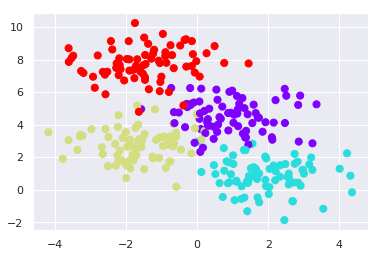

In [0]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

In [0]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

In [0]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
  ax = ax or plt.gca()
  
  # Plot the training points
  ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap, clim=(y.min(), y.max()), zorder=3)
  ax.axis('tight')
  ax.axis('off')
  xlim = ax.get_xlim()
  ylim = ax.get_ylim()
  
  # fit the estimator
  model.fit(X, y)
  xx, yy = np.meshgrid(np.linspace(*xlim, num=200), np.linspace(*ylim, num=200))
  Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
  
  # Create a color plot with the results
  n_classes = len(np.unique(y))
  contours = ax.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(n_classes + 1) - 0.5, cmap=cmap, zorder=1)
  ax.set(xlim=xlim, ylim=ylim)

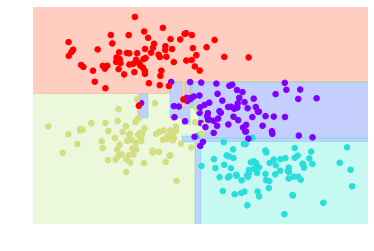

In [0]:
visualize_classifier(DecisionTreeClassifier(), X, y)

In [0]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.0)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from ipywidgets import interact


def visualize_tree(estimator, X, y, boundaries=True, xlim=None, ylim=None, ax=None):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis', clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()
    
    # fit the estimator
    estimator.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200), np.linspace(*ylim, num=200))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    n_classes = len(np.unique(y))
    Z = Z.reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(n_classes + 1) - 0.5, cmap='viridis', zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    
    # Plot the decision boundaries
    def plot_boundaries(i, xlim, ylim):
        if i >= 0:
            tree = estimator.tree_
        
            if tree.feature[i] == 0:
                ax.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k', zorder=2)
                plot_boundaries(tree.children_left[i], [xlim[0], tree.threshold[i]], ylim)
                plot_boundaries(tree.children_right[i], [tree.threshold[i], xlim[1]], ylim)
        
            elif tree.feature[i] == 1:
                ax.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k', zorder=2)
                plot_boundaries(tree.children_left[i], xlim, [ylim[0], tree.threshold[i]])
                plot_boundaries(tree.children_right[i], xlim, [tree.threshold[i], ylim[1]])
            
    if boundaries:
        plot_boundaries(0, xlim, ylim)


def plot_tree_interactive(X, y):
    def interactive_tree(depth=5):
        clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
        visualize_tree(clf, X, y)

    return interact(interactive_tree, depth=[1, 2, 3, 4, 5])
    
plot_tree_interactive(X, y);

interactive(children=(Dropdown(description='depth', index=4, options=(1, 2, 3, 4, 5), value=5), Output()), _do…

##Decision trees and overfitting

Such overfitting turns out to be a general property of decision trees; it is very easy to go too deep in the tree, and thus to fit details of the particular data rather than the overall properties.

In [0]:
def randomized_tree_interactive(X, y):
    N = int(0.75 * X.shape[0])
    
    xlim = (X[:, 0].min(), X[:, 0].max())
    ylim = (X[:, 1].min(), X[:, 1].max())
    
    def fit_randomized_tree(random_state=0):
        clf = DecisionTreeClassifier(max_depth=15)
        i = np.arange(len(y))
        rng = np.random.RandomState(random_state)
        rng.shuffle(i)
        visualize_tree(clf, X[i[:N]], y[i[:N]], boundaries=False, xlim=xlim, ylim=ylim)
    
    interact(fit_randomized_tree, random_state=[0, 5, 10, 20, 50, 75, 100]);
    
randomized_tree_interactive(X, y)

interactive(children=(Dropdown(description='random_state', options=(0, 5, 10, 20, 50, 75, 100), value=0), Outp…

#Ensembles of Estimators: Random Forests

This notion—that multiple overfitting estimators can be combined to reduce the effect of this overfitting—is what underlies an ensemble method called **bagging**. Bagging makes use of an ensemble (a grab bag, perhaps) of parallel estimators, each of which overfits the data, and averages the results to find a better classification. An ensemble of randomized decision trees is known as a **random forest**.

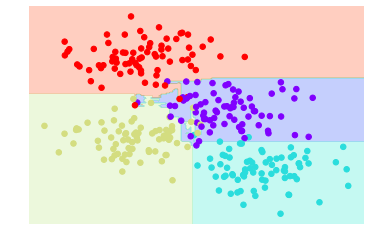

In [0]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
  ax = ax or plt.gca()
  
  # Plot the training points
  ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap, clim=(y.min(), y.max()), zorder=3)
  ax.axis('tight')
  ax.axis('off')
  xlim = ax.get_xlim()
  ylim = ax.get_ylim()
  
  # fit the estimator
  model.fit(X, y)
  xx, yy = np.meshgrid(np.linspace(*xlim, num=200), np.linspace(*ylim, num=200))
  Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
  
  # Create a color plot with the results
  n_classes = len(np.unique(y))
  contours = ax.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(n_classes + 1) - 0.5, cmap=cmap, zorder=1)
  ax.set(xlim=xlim, ylim=ylim)
  

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1)
bag.fit(X, y)

visualize_classifier(bag, X, y)

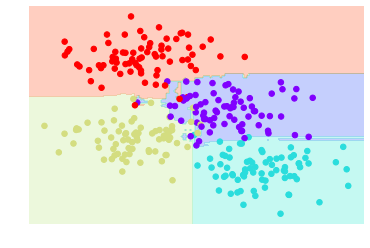

In [0]:
# RandomForestClassifier takes care of all the desired randomness
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);
#averaging over 100 randomly perturbed models, we end up with an overall model that is much closer to our intuition

#Random Forest Regression

Random forests can also be made to work in the case of regression (that is, continuous rather than categorical variables)

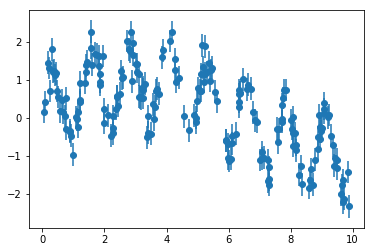

In [0]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
  fast_oscillation = np.sin(5 * x)
  slow_oscillation = np.sin(0.5 * x)
  noise = sigma * rng.randn(len(x))
  return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

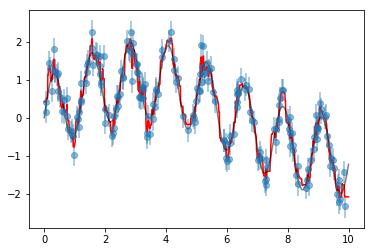

In [0]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

# random forest model is flexible enough to fit the multiperiod data, 
# without us needing to specify a multiperiod model!

#Example: Random Forest for Classifying Digits

In [0]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

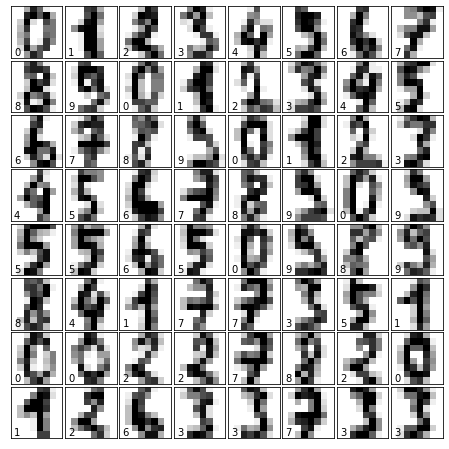

In [0]:
import matplotlib.pyplot as plt

# set up the figure
fig = plt.figure(figsize=(6, 6)) # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
  ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
  ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
  
  # label the image with the target value
  ax.text(0, 7, str(digits.target[i]))

[ 0.  1.  9. 16. 13.  7.  0.  0.  0.  7. 14.  4. 10. 12.  0.  0.  0.  6.
 15.  9. 16. 11.  0.  0.  0.  0.  9. 11.  7. 14.  0.  0.  0.  0.  0.  0.
  0. 15.  2.  0.  0.  0.  0.  0.  0. 11.  6.  0.  0.  3. 13.  8.  5. 14.
  5.  0.  0.  0.  9. 14. 13. 10.  1.  0.]
[[ 0.  1.  9. 16. 13.  7.  0.  0.]
 [ 0.  7. 14.  4. 10. 12.  0.  0.]
 [ 0.  6. 15.  9. 16. 11.  0.  0.]
 [ 0.  0.  9. 11.  7. 14.  0.  0.]
 [ 0.  0.  0.  0.  0. 15.  2.  0.]
 [ 0.  0.  0.  0.  0. 11.  6.  0.]
 [ 0.  3. 13.  8.  5. 14.  5.  0.]
 [ 0.  0.  9. 14. 13. 10.  1.  0.]]


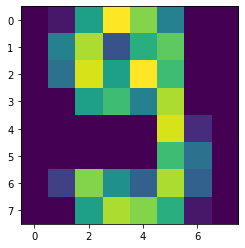

In [0]:
print(digits.data[39])
print(digits.images[39])
plt.imshow(digits.images[39])

In [0]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target, random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.98      0.98        43
           2       0.95      1.00      0.98        42
           3       0.98      0.98      0.98        45
           4       0.97      1.00      0.99        37
           5       0.98      0.96      0.97        49
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.96      0.98      0.97        47
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



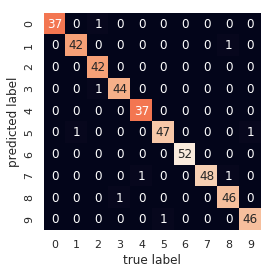

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()

mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

#Summary of Random Forests

*   Both training and prediction are very fast, because of the simplicity of the underlying decision trees. In addition, both tasks can be straightforwardly parallelized, because the individual trees are entirely independent entities.
*   The multiple trees allow for a probabilistic classification: a majority vote among estimators gives an estimate of the probability (accessed in Scikit-Learn with the predict_proba() method).
*   The nonparametric model is extremely flexible, and can thus perform well on
tasks that are underfit by other estimators.

**Disadvantage**

results are not easily interpretable

#Test area

Piet Mondriaan, Composition with Red, Blue, and Yellow (1930)

![](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a4/Piet_Mondriaan%2C_1930_-_Mondrian_Composition_II_in_Red%2C_Blue%2C_and_Yellow.jpg/591px-Piet_Mondriaan%2C_1930_-_Mondrian_Composition_II_in_Red%2C_Blue%2C_and_Yellow.jpg)


In [0]:
from sklearn.tree import DecisionTreeClassifier

def fit_tree(X, y, depth=1):
  model = DecisionTreeClassifier(max_depth=depth, random_state=0)
  model.fit(X, y)
  return model

In [0]:
#@title #Visualization code
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def visualize_tree(estimator, X, y, boundaries=True):
  fig = plt.figure(figsize=(10,10))
  ax = fig.gca()
  ax.tick_params(axis="y",direction="in", pad=-30)
  ax.tick_params(axis="x",direction="in", pad=-15)
  ax.set_xticks(np.arange(-.75, 1, .25))
  ax.set_yticks(np.arange(-.75, 1, .25))
  
  # Plot the training points
  rgb = [[210, 0, 0], [0, 0, 150], [107, 142, 35], [150, 0, 150], [220, 105, 0]]
    
  rgb=np.array(rgb)/255.
  ax.scatter(X[:, 0], X[:, 1], c=rgb[y], s=30, zorder=3)
  ax.axis('tight')
  ax.axis('off')
  xlim = [-1, 1]
  ylim = [-1, 1]
  ax.set_xlim(xlim)
  ax.set_ylim(ylim)
  
  xx, yy = np.meshgrid(np.linspace(*xlim, num=200), np.linspace(*ylim, num=200))
  Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  n_classes = 5#len(np.unique(y))
  Z = Z.reshape(xx.shape)
  contours = ax.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(n_classes + 1) - 0.5, cmap=ListedColormap(rgb), zorder=1)
  
  # Plot the decision boundaries
  def plot_boundaries(i, xlim, ylim):
      if i >= 0:
          tree = estimator.tree_
      
          if tree.feature[i] == 0:
              ax.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k', zorder=2)
              plot_boundaries(tree.children_left[i], [xlim[0], tree.threshold[i]], ylim)
              plot_boundaries(tree.children_right[i], [tree.threshold[i], xlim[1]], ylim)
      
          elif tree.feature[i] == 1:
              ax.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k', zorder=2)
              plot_boundaries(tree.children_left[i], xlim, [ylim[0], tree.threshold[i]])
              plot_boundaries(tree.children_right[i], xlim, [tree.threshold[i], ylim[1]])
          
  if boundaries:
      plot_boundaries(0, xlim, ylim)

  plt.close(fig)

  return fig

import base64
import io

def figure_to_base64(fig):
  buf = io.BytesIO()
  fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0);
  image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8').replace('\n', '')
  buf.close()
  return image_base64

import json

def invoke(pts):
  data = np.array(pts).reshape((-1, 3))
  X = data[:, :2] / 300.0 - 1.0
  X[:, 1] *= -1.0
  y = data[:, 2]

  images = []
  for depth in range(1, 10):
    clf = fit_tree(X, y, depth)
    fig = visualize_tree(clf, X, y)
    images.append(figure_to_base64(fig))

  return IPython.display.JSON({'image': images})


import IPython
from google.colab import output

main_str = '''
  <script type="application/javascript">
  
    var active_pt = null;
    var all_pts = [];
    var class_btn = [[650, 50], [650, 150], [650, 250], [650, 350], [650, 450]];
    var class_name = ["class A", "class B", "class C", "class D", "class E"];
    var class_color = ["rgba(210, 0, 0, 0.75)", "rgba(0, 0, 150, 0.75)", 
         "rgba(107, 142, 35, 0.95)", "rgba(150, 0, 150, 0.75)", "rgba(220, 105, 0, 0.75)"]

    var ptR = 10.0;
    var params = null;
    var debug_txt = "";
    var bg_image = new Image();

    function is_close(pt1, pt2) {
      return   (pt1[0] - pt2[0])*(pt1[0] - pt2[0])
            +  (pt1[1] - pt2[1])*(pt1[1] - pt2[1])
            <= ptR*ptR;
    }
  
    function circ(ctx, pos, cls) {
      ctx.beginPath();
      ctx.arc(pos[0], pos[1], ptR, 0.0, 2.0 * Math.PI, 0);
      ctx.fillStyle = class_color[cls];
      ctx.fill();
    }
    
    function draw() {
      var canvas = document.getElementById('canvas');
      if (canvas.getContext) {
        var ctx = canvas.getContext('2d');
        
        ctx.clearRect(0, 0, canvas.width, canvas.height); // cleanup before start
        ctx.drawImage(bg_image, 0, 0, 600, 600);
        ctx.strokeRect(0, 0, 600, 600); // field
        
        for (var i = 0; i < 5; i++) {
          ctx.font = '20px serif';
          ctx.fillStyle = 'black';
          ctx.fillText(class_name[i], 700,  50 + 100*i);
          circ(ctx, class_btn[i], i);
          ctx.strokeRect(625, 25 + 100*i, 150, 50);
        }

        ctx.fillText(debug_txt, 200, 200);

        if (active_pt) {
          circ(ctx, [active_pt[0], active_pt[1]], active_pt[2]);
        }
        all_pts.forEach(function (item, index) {
          circ(ctx, [item[0], item[1]], item[2]);
        });

      }
    }
    
    var timer
    function init() {
      timer = setInterval(draw, 10);
    }
    
    function mdown_handle(evt) {
      x = evt.offsetX;
      y = evt.offsetY;
      for (var i = 0; i < 5; i++) { 
        if (is_close([x,y], class_btn[i])) { 
          active_pt = [x, y, i]
        }
      }

      idx = -1;
      all_pts.forEach(function (item, index) {
        if (is_close([x,y], [item[0], item[1]])) {
          idx = index;
        }
      });
      if (idx > -1) {
        active_pt = all_pts[idx];
        all_pts.splice(idx, 1);
      }
    }
    
    function mmove_handle(evt) {
      x = evt.offsetX;
      y = evt.offsetY;
      if (active_pt) {
        active_pt[0] = x;
        active_pt[1] = y;
      }
    }
    
    function mup_handle(evt) {
      x = evt.offsetX;
      y = evt.offsetY;
      if (x >= 600) {
        active_pt = null;
      }
      if (active_pt) {
        all_pts.push(active_pt);
        active_pt = null;
      }
    }
    
    var cur_depth = 0;

    async function calculate() {
      if (!all_pts)
        return;
      var merged = [].concat.apply([], all_pts);
      const result = await google.colab.kernel.invokeFunction('notebook.InvSVM', [merged], {});
      params = result.data['application/json'];
      bg_image.src = 'data:image/  png;base64,' + params.image[cur_depth];
    }

  function h_change(x) {
    el = document.getElementById("slider_val");
    cur_depth = x - 1;
    el.innerHTML = x;
    bg_image.src = 'data:image/  png;base64,' + params.image[cur_depth];
  }

  </script>
  <canvas id="canvas" width="800" height="600" 
    onmousedown="mdown_handle(event)"
    onmousemove="mmove_handle(event)"
    onmouseup="mup_handle(event)"></canvas>
  <div style="position:absolute; top:500px; left:625px;">
    <button type="button" onclick="calculate();">
      Invoke Decision Tree
    </button>
    <br><br>Tree Depth:<br>
    <input type="range" min="1" max="9" value="1" oninput="h_change(this.value)">
    <br><div id="slider_val">1</div>
  </div>
  <script> init();</script>
'''



def generate_html():
  s = main_str
  return s
  
display(IPython.display.HTML(generate_html()))
    
    
output.register_callback('notebook.InvSVM', invoke)

In [0]:
from sklearn.datasets import load_digits
digits = load_digits()

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

model = RandomForestClassifier(n_estimators=1000)
model.fit(digits.data, digits.target)

print(digits.target.shape)

# Important note:
# This function gets a single 2D array 8x8 representing image
# while predictor accepts Nx16 array,
# where N is number of images (1 in our case).
# Do not forget to transform data appropriately.
def process_symbol(array_8x8):
  num_pred = model.predict([array_8x8.ravel()])[0]
  return num_pred

(1797,)


In [0]:
#@title #Visualization code
import IPython
from google.colab import output
import numpy as np
import json

def do_recognition(array_8x8):
  arr = np.transpose(np.array(array_8x8))
  return IPython.display.JSON({'msg': process_symbol(arr)})

main_str = '''
<body>
  	<div id="paint">
  		<canvas id="myCanvas" width="600" height="600" 
              onmousedown="start_paint(event)"
              onmousemove="do_paint(event)"
              onmouseup="stop_paint(event)"
              style="border:3px solid #000000;">
      </canvas>
	  </div>
    <div style="position:absolute; top:0px; left:625px;">
        <h2> Cropped image </h2>
        <img id="partial_image" style="width:80px; height:80px; border:3px solid #000000;">
        <h2> 8x8x16 grayscale colors </h2>
        <canvas id="bin_canvas" width="80" height="80" 
              style="border:3px solid #000000;">
        </canvas>
        <h2> Recognize symbol </h2>
        <button type="button" onclick="process_data();">
        Do recognition
        </button>
        <h2> Clean canvas </h2>
        <button type="button" onclick="clear_canvas();">
        Clean
        </button>
        <h2> Recognition result </h2>
        <div id="rec_res" style="font-size:40px;"></div>
    </div>
<script>

var canvas = document.getElementById('myCanvas');
var ctx = canvas.getContext('2d');
var ctx_2 = document.getElementById("bin_canvas").getContext("2d");
var mouse = {x: 0, y: 0, state: 0, min_x: 600, max_x: 0, min_y: 600, max_y: 0};
var full_image = ctx.getImageData(0, 0, 600, 600);
var partial_image = document.getElementById('partial_image');
var binarized = [[0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0]]

ctx.lineJoin = 'round';
ctx.lineCap = 'round';

 
function start_paint(e)
{
  ctx.putImageData(full_image, 0, 0);
  mouse.state = 1;
  ctx.beginPath();
  ctx.moveTo(mouse.x, mouse.y);
}

function do_paint(e)
{
  mouse.x = e.pageX - 10;
  mouse.y = e.pageY - 10;
  if (!mouse.state)
    return;
  ctx.lineTo(mouse.x, mouse.y);
  ctx.lineWidth = 10;
  ctx.strokeStyle = '#000000';
  ctx.stroke();
  full_image = ctx.getImageData(0, 0, 600, 600);
  if (mouse.min_x > mouse.x)
    mouse.min_x = mouse.x;
  if (mouse.min_y > mouse.y)
    mouse.min_y = mouse.y;
  if (mouse.max_x < mouse.x)
    mouse.max_x = mouse.x;
  if (mouse.max_y < mouse.y)
    mouse.max_y = mouse.y;
}

function stop_paint(e)
{
  mouse.state = 0;
  full_image = ctx.getImageData(0, 0, 600, 600);

  c_x = (mouse.max_x + mouse.min_x) / 2;
  c_y = (mouse.max_y + mouse.min_y) / 2;
  a = Math.max(mouse.max_x - mouse.min_x, mouse.max_y - mouse.min_y);
  a += 7;
  var part = ctx.getImageData(c_x - a/2, c_y - a/2, a, a);
  partial_image.src = getImageURL(part);

  for (var i = 0; i < 8; i++)
    for (var j = 0; j < 8; j++)
      binarized[i][j] = 0;

  for (var idx_y = 0; idx_y < part.height; idx_y += 1)
    for (var idx_x = 0; idx_x < part.width; idx_x += 1)
      if (part.data[idx_y * part.width * 4 + idx_x * 4 + 3] > 1)
      	binarized[Math.floor(8 * idx_x / part.width)][Math.floor(8 * idx_y / part.height)] += 1;
      	
  for (var i = 0; i < 8; i++)
    for (var j = 0; j < 8; j++)
      binarized[i][j] = Math.floor(16 * binarized[i][j] / (part.width * part.height) * (8*8));

  for (var i = 0; i < 8; i++)
    for (var j = 0; j < 8; j++)
    {
      ctx_2.fillStyle = "rgba(" + [256 - 16*binarized[i][j], 256 - 16*binarized[i][j], 256 - 16*binarized[i][j], 255].join(",") + ")";
      ctx_2.fillRect(i * 10, j * 10, 10, 10);
    }
  
  ctx.lineWidth = 2;
  ctx.strokeStyle = '#FF0000';
  ctx.strokeRect(c_x - a/2, c_y - a/2, a, a);
}

function getImageURL(imgData)
{
   var canvas = document.createElement('canvas');
   var ctx = canvas.getContext('2d');
   canvas.width = imgData.width;
   canvas.height = imgData.height;
   ctx.putImageData(imgData, 0, 0);
   return canvas.toDataURL(); //image URL
}

async function process_data()
{
  const result = await google.colab.kernel.invokeFunction('notebook.DoRec', [binarized], {});
  params = result.data['application/json'];
  document.getElementById('rec_res').innerHTML = params.msg;
}

function clear_canvas()
{
  mouse = {x: 0, y: 0, state: 0, min_x: 600, max_x: 0, min_y: 600, max_y: 0};
  binarized = [[0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0]];
  ctx.clearRect(0, 0, canvas.width, canvas.height); 
  full_image = ctx.getImageData(0, 0, 600, 600);  
  ctx_2.clearRect(0, 0, 80, 80);   
  var part = ctx.getImageData(0, 0, 80, 80);
  partial_image.src = getImageURL(part);
  document.getElementById('rec_res').innerHTML = "";
}

    </script>
  </body>
'''

display(IPython.display.HTML(main_str))
output.register_callback('notebook.DoRec', do_recognition)

downloaded MNIST shape:  (70000, 784) (70000,)
Normalized images to: 0.0 1.0
[5 0 4 1 9]


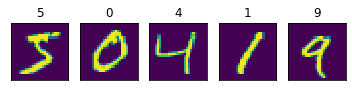

In [0]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

mnist = fetch_openml('mnist_784', cache=False)
print("downloaded MNIST shape: ", mnist.data.shape, mnist.target.shape)
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')
X /= 255.0
print("Normalized images to:", X.min(), X.max())
for i, (img, y_) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
    plt.subplot(151 + i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title(y_)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100)
model.fit(X, y)
print(model.predict(X[:5]))

In [0]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)
print(tree.predict(X[:5]))

[5 0 4 1 9]


In [0]:
#plt.imshow(X[4].reshape(28,28))
#plt.xticks([])
#plt.yticks([])
#plt.title(9)

def process_symbol(num_img):
  num_pred = tree.predict([num_img.ravel()])[0]
  #plt.imshow(num_img)
  #plt.xticks([])
  #plt.yticks([])
  #plt.title(num_pred)
  return num_pred

In [0]:
#@title #Visualization code
import IPython
from google.colab import output
import numpy as np
import json

def do_recognition(array_8x8):
  arr = np.transpose(np.array(array_8x8))
  return IPython.display.JSON({'msg': process_symbol(arr)})

main_str = '''
<body>
  	<div id="paint">
  		<canvas id="myCanvas" width="600" height="600" 
              onmousedown="start_paint(event)"
              onmousemove="do_paint(event)"
              onmouseup="stop_paint(event)"
              style="border:3px solid #000000;">
      </canvas>
	  </div>
    <div style="position:absolute; top:0px; left:625px;">
        <h2> Cropped image </h2>
        <img id="partial_image" style="width:80px; height:80px; border:3px solid #000000;">
        <h2> Scaled </h2>
        <canvas id="bin_canvas" width="80" height="80" 
              style="border:3px solid #000000;">
        </canvas>
        <h2> Recognize symbol </h2>
        <button type="button" onclick="process_data();">
        Do recognition
        </button>
        <h2> Clean canvas </h2>
        <button type="button" onclick="clear_canvas();">
        Clean
        </button>
        <h2> Recognition result </h2>
        <div id="rec_res" style="font-size:40px;"></div>
    </div>
<script>

var canvas = document.getElementById('myCanvas');
var ctx = canvas.getContext('2d');
var canvas_2 = document.getElementById("bin_canvas");
var ctx_2 = canvas_2.getContext("2d");
var mouse = {x: 0, y: 0, state: 0, min_x: 600, max_x: 0, min_y: 600, max_y: 0};
var full_image = ctx.getImageData(0, 0, 600, 600);
var partial_image = document.getElementById('partial_image');
var binarized = null;

var N_scaled = 28;

ctx.lineJoin = 'round';
ctx.lineCap = 'round';

 
function start_paint(e)
{
  ctx.putImageData(full_image, 0, 0);
  mouse.state = 1;
  ctx.beginPath();
  ctx.moveTo(mouse.x, mouse.y);
}

var line_width = 28;

function do_paint(e)
{
  mouse.x = e.pageX - 10;
  mouse.y = e.pageY - 10;
  if (!mouse.state)
    return;
  ctx.lineTo(mouse.x, mouse.y);
  ctx.lineWidth = line_width;
  ctx.strokeStyle = '#000000';
  ctx.stroke();
  full_image = ctx.getImageData(0, 0, 600, 600);
  if (mouse.min_x > mouse.x)
    mouse.min_x = mouse.x;
  if (mouse.min_y > mouse.y)
    mouse.min_y = mouse.y;
  if (mouse.max_x < mouse.x)
    mouse.max_x = mouse.x;
  if (mouse.max_y < mouse.y)
    mouse.max_y = mouse.y;
}

function stop_paint(e)
{
  mouse.state = 0;
  full_image = ctx.getImageData(0, 0, 600, 600);

  c_x = (mouse.max_x + mouse.min_x) / 2;
  c_y = (mouse.max_y + mouse.min_y) / 2;
  a = Math.max(mouse.max_x - mouse.min_x, mouse.max_y - mouse.min_y);
  a += line_width;
  var part = ctx.getImageData(c_x - a/2, c_y - a/2, a, a);
  partial_image.src = getImageURL(part);

  binarized = Array(N_scaled).fill(0).map(x => Array(N_scaled).fill(0))
  var counts = Array(N_scaled).fill(0).map(x => Array(N_scaled).fill(0))

  for (var idx_y = 0; idx_y < part.height; idx_y += 1)
    for (var idx_x = 0; idx_x < part.width; idx_x += 1)
    {
      counts[Math.floor(N_scaled * idx_x / part.width)][Math.floor(N_scaled * idx_y / part.height)] += 1;
      if (part.data[idx_y * part.width * 4 + idx_x * 4 + 3] > 1)
      	binarized[Math.floor(N_scaled * idx_x / part.width)][Math.floor(N_scaled * idx_y / part.height)] += 1;
    }
      	
  for (var i = 0; i < N_scaled; i++)
    for (var j = 0; j < N_scaled; j++)
      binarized[i][j] = binarized[i][j] / counts[i][j];

  ctx_2.fillStyle = "rgba(255, 255, 255, 255)";
  ctx_2.fillRect(0, 0, canvas_2.width, canvas_2.height);
  for (var i = 0; i < N_scaled; i++)
    for (var j = 0; j < N_scaled; j++)
    {
      var c = Math.floor(255 - 255*binarized[i][j]);
      var x = Math.floor(canvas_2.width / N_scaled * i);
      var y = Math.floor(canvas_2.height / N_scaled * j);
      var dx = Math.floor(canvas_2.width / N_scaled + 1);
      var dy = Math.floor(canvas_2.height / N_scaled + 1);
      ctx_2.fillStyle = "rgba(" + [c, c, c, 255].join(",") + ")";
      ctx_2.fillRect(x, y, dx, dy);
    }
  
  ctx.lineWidth = 2;
  ctx.strokeStyle = '#FF0000';
  ctx.strokeRect(c_x - a/2, c_y - a/2, a, a);
}

function getImageURL(imgData)
{
   var canvas = document.createElement('canvas');
   var ctx = canvas.getContext('2d');
   canvas.width = imgData.width;
   canvas.height = imgData.height;
   ctx.putImageData(imgData, 0, 0);
   return canvas.toDataURL(); //image URL
}

async function process_data()
{
  const result = await google.colab.kernel.invokeFunction('notebook.DoRec', [binarized], {});
  params = result.data['application/json'];
  document.getElementById('rec_res').innerHTML = params.msg;
}

function clear_canvas()
{
  mouse = {x: 0, y: 0, state: 0, min_x: 600, max_x: 0, min_y: 600, max_y: 0};
  binarized = null;
  ctx.clearRect(0, 0, canvas.width, canvas.height); 
  full_image = ctx.getImageData(0, 0, 600, 600);  
  ctx_2.clearRect(0, 0, 80, 80);   
  var part = ctx.getImageData(0, 0, 80, 80);
  partial_image.src = getImageURL(part);
  document.getElementById('rec_res').innerHTML = "";
}

    </script>
  </body>
'''

display(IPython.display.HTML(main_str))
output.register_callback('notebook.DoRec', do_recognition)

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

class Canvas:
  def __init__(self):
    self.clear()

  def clear(self):
    self.image = np.zeros((100, 100), np.uint8)

  def stroke(self, key_points_arr):
    x0, y0 = key_points_arr[0]
    for x,y in key_points_arr[1:]:
      cv2.line(self.image, (x0, y0), (x, y), (255), 3) # 3 = line_thickness
      x0, y0 = x, y

  def _get_square_frame(self):
    pos = np.nonzero(self.image)
    x_c, y_c = (pos[1].min() + pos[1].max())/2, (pos[0].min() + pos[0].max())/2
    d = np.max([(pos[1].max() - pos[1].min())/2, (pos[0].max() - pos[0].min())/2])
    return x_c, y_c, d

  def rotate(self, angle_degrees):
    x_c, y_c, _ = self._get_square_frame()
    rot_mat = cv2.getRotationMatrix2D((x_c, y_c), angle_degrees, 1.0)
    self.image = cv2.warpAffine(self.image, rot_mat, self.image.shape[1::-1], flags=cv2.INTER_LINEAR)

  def blur(self, strength=2):
    self.image = cv2.GaussianBlur(self.image, (2*strength+1, 2*strength+1), 0)

  def get_full_image(self):
    return self.image

  def get_scaled_image(self):
    x_c, y_c, d = self._get_square_frame()
    crop_img = self.image[int(y_c - d):int(y_c + d), int(x_c - d):int(x_c + d)]
    scaled_img = cv2.resize(crop_img, (28, 28))
    return scaled_img / 255.0

  def get_array_for_dataset(self):
    return self.get_scaled_image().ravel()

  def draw(self):
    plt.subplot(121)
    plt.imshow(self.image)
    plt.xticks([])
    plt.yticks([])
    plt.title("Full image")
    plt.subplot(122)
    plt.imshow(self.get_scaled_image())
    plt.xticks([])
    plt.yticks([])
    plt.title("Scaled for dataset")
    plt.show()


In [168]:
X = []
y = []
c = Canvas()

for a in [-10, -5, 0, 5, 10]:
  c.stroke([[20, 20], [20, 40], [40, 40]])
  c.rotate(a)
  X.append(c.get_array_for_dataset())
  y.append(0)
#c.draw()

c.clear()
for a in [-10, -5, 0, 5, 10]:
  c.stroke([[20, 40], [40, 40], [40, 20]])
  c.rotate(a)
  X.append(c.get_array_for_dataset())
  y.append(1)

from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)
print(tree.predict(X))

[0 0 0 0 0 1 1 1 1 1]


In [0]:
names = {0: "L", 1:"anti-L"}

def process_symbol(num_img):
  num_pred = tree.predict([num_img.ravel()])[0]
  return names[num_pred]

In [126]:
#@title #Visualization code
import IPython
from google.colab import output
import numpy as np
import json

def do_recognition(array_8x8):
  arr = np.transpose(np.array(array_8x8))
  return IPython.display.JSON({'msg': process_symbol(arr)})

main_str = '''
<body>
  	<div id="paint">
  		<canvas id="myCanvas" width="600" height="600" 
              onmousedown="start_paint(event)"
              onmousemove="do_paint(event)"
              onmouseup="stop_paint(event)"
              style="border:3px solid #000000;">
      </canvas>
	  </div>
    <div style="position:absolute; top:0px; left:625px;">
        <h2> Cropped image </h2>
        <img id="partial_image" style="width:80px; height:80px; border:3px solid #000000;">
        <h2> Scaled </h2>
        <canvas id="bin_canvas" width="80" height="80" 
              style="border:3px solid #000000;">
        </canvas>
        <h2> Recognize symbol </h2>
        <button type="button" onclick="process_data();">
        Do recognition
        </button>
        <h2> Clean canvas </h2>
        <button type="button" onclick="clear_canvas();">
        Clean
        </button>
        <h2> Recognition result </h2>
        <div id="rec_res" style="font-size:40px;"></div>
    </div>
<script>

var canvas = document.getElementById('myCanvas');
var ctx = canvas.getContext('2d');
var canvas_2 = document.getElementById("bin_canvas");
var ctx_2 = canvas_2.getContext("2d");
var mouse = {x: 0, y: 0, state: 0, min_x: 600, max_x: 0, min_y: 600, max_y: 0};
var full_image = ctx.getImageData(0, 0, 600, 600);
var partial_image = document.getElementById('partial_image');
var binarized = null;

var N_scaled = 28;

ctx.lineJoin = 'round';
ctx.lineCap = 'round';

 
function start_paint(e)
{
  ctx.putImageData(full_image, 0, 0);
  mouse.state = 1;
  ctx.beginPath();
  ctx.moveTo(mouse.x, mouse.y);
}

var line_width = 28;

function do_paint(e)
{
  mouse.x = e.pageX - 10;
  mouse.y = e.pageY - 10;
  if (!mouse.state)
    return;
  ctx.lineTo(mouse.x, mouse.y);
  ctx.lineWidth = line_width;
  ctx.strokeStyle = '#000000';
  ctx.stroke();
  full_image = ctx.getImageData(0, 0, 600, 600);
  if (mouse.min_x > mouse.x)
    mouse.min_x = mouse.x;
  if (mouse.min_y > mouse.y)
    mouse.min_y = mouse.y;
  if (mouse.max_x < mouse.x)
    mouse.max_x = mouse.x;
  if (mouse.max_y < mouse.y)
    mouse.max_y = mouse.y;
}

function stop_paint(e)
{
  mouse.state = 0;
  full_image = ctx.getImageData(0, 0, 600, 600);

  c_x = (mouse.max_x + mouse.min_x) / 2;
  c_y = (mouse.max_y + mouse.min_y) / 2;
  a = Math.max(mouse.max_x - mouse.min_x, mouse.max_y - mouse.min_y);
  a += line_width;
  var part = ctx.getImageData(c_x - a/2, c_y - a/2, a, a);
  partial_image.src = getImageURL(part);

  binarized = Array(N_scaled).fill(0).map(x => Array(N_scaled).fill(0))
  var counts = Array(N_scaled).fill(0).map(x => Array(N_scaled).fill(0))

  for (var idx_y = 0; idx_y < part.height; idx_y += 1)
    for (var idx_x = 0; idx_x < part.width; idx_x += 1)
    {
      counts[Math.floor(N_scaled * idx_x / part.width)][Math.floor(N_scaled * idx_y / part.height)] += 1;
      if (part.data[idx_y * part.width * 4 + idx_x * 4 + 3] > 1)
      	binarized[Math.floor(N_scaled * idx_x / part.width)][Math.floor(N_scaled * idx_y / part.height)] += 1;
    }
      	
  for (var i = 0; i < N_scaled; i++)
    for (var j = 0; j < N_scaled; j++)
      binarized[i][j] = binarized[i][j] / counts[i][j];

  ctx_2.fillStyle = "rgba(255, 255, 255, 255)";
  ctx_2.fillRect(0, 0, canvas_2.width, canvas_2.height);
  for (var i = 0; i < N_scaled; i++)
    for (var j = 0; j < N_scaled; j++)
    {
      var c = Math.floor(255 - 255*binarized[i][j]);
      var x = Math.floor(canvas_2.width / N_scaled * i);
      var y = Math.floor(canvas_2.height / N_scaled * j);
      var dx = Math.floor(canvas_2.width / N_scaled + 1);
      var dy = Math.floor(canvas_2.height / N_scaled + 1);
      ctx_2.fillStyle = "rgba(" + [c, c, c, 255].join(",") + ")";
      ctx_2.fillRect(x, y, dx, dy);
    }
  
  ctx.lineWidth = 2;
  ctx.strokeStyle = '#FF0000';
  ctx.strokeRect(c_x - a/2, c_y - a/2, a, a);
}

function getImageURL(imgData)
{
   var canvas = document.createElement('canvas');
   var ctx = canvas.getContext('2d');
   canvas.width = imgData.width;
   canvas.height = imgData.height;
   ctx.putImageData(imgData, 0, 0);
   return canvas.toDataURL(); //image URL
}

async function process_data()
{
  const result = await google.colab.kernel.invokeFunction('notebook.DoRec', [binarized], {});
  params = result.data['application/json'];
  document.getElementById('rec_res').innerHTML = params.msg;
}

function clear_canvas()
{
  mouse = {x: 0, y: 0, state: 0, min_x: 600, max_x: 0, min_y: 600, max_y: 0};
  binarized = null;
  ctx.clearRect(0, 0, canvas.width, canvas.height); 
  full_image = ctx.getImageData(0, 0, 600, 600);  
  ctx_2.clearRect(0, 0, 80, 80);   
  var part = ctx.getImageData(0, 0, 80, 80);
  partial_image.src = getImageURL(part);
  document.getElementById('rec_res').innerHTML = "";
}

    </script>
  </body>
'''

display(IPython.display.HTML(main_str))
output.register_callback('notebook.DoRec', do_recognition)